In [1]:
import sys
sys.path.append('..')
import torch
import pandas as pd
import numpy as np
import pickle
import argparse
import networkx as nx
from torch_geometric.utils import dense_to_sparse, degree
import matplotlib.pyplot as plt
from src.gcn import GCNSynthetic
from src.utils.utils import normalize_adj, get_neighbourhood

### Syn5 dataset (tree grid) , best params so far: SGD, epochs=500, LR=0.1, beta=0.5

#### Uses correct version of symmetry constraint

#### For tree-grid, class 0 = base tree, class 1 = grid

In [2]:
header = ["node_idx", "new_idx", "cf_adj", "sub_adj", "y_pred_cf", "y_pred_orig",
            "label", "num_nodes", "node_dict", "loss_graph_dist"]

In [3]:
# For original model
dataset = "syn5"
hidden = 20
seed = 42
dropout = 0.0


# Load original dataset and model

with open("../data/gnn_explainer/{}.pickle".format(dataset), "rb") as f:
	data = pickle.load(f)

adj = torch.Tensor(data["adj"]).squeeze()       # Does not include self loops
features = torch.Tensor(data["feat"]).squeeze()
labels = torch.tensor(data["labels"]).squeeze()
idx_train = torch.tensor(data["train_idx"])
idx_test = torch.tensor(data["test_idx"])
edge_index = dense_to_sparse(adj)

norm_adj = normalize_adj(adj)

model = GCNSynthetic(nfeat=features.shape[1], nhid=hidden, nout=hidden,
                     nclass=len(labels.unique()), dropout=dropout)
model.load_state_dict(torch.load("../models/gcn_3layer_{}.pt".format(dataset)))
model.eval()
output = model(features, norm_adj)
y_pred_orig = torch.argmax(output, dim=1)
print("test set y_true counts: {}".format(np.unique(labels[idx_test].numpy(), return_counts=True)))
print("test set y_pred_orig counts: {}".format(np.unique(y_pred_orig[idx_test].numpy(), return_counts=True)))
print("Whole graph counts: {}".format(np.unique(labels.numpy(), return_counts=True)))

test set y_true counts: (array([0, 1]), array([108, 139]))
test set y_pred_orig counts: (array([0, 1]), array([ 97, 150]))
Whole graph counts: (array([0, 1]), array([511, 720]))


In [4]:
# Load cf examples for test set
with open("../baselines/results/keep_ego/{}_baseline_cf_examples".format(dataset), "rb") as f:

    cf_examples = pickle.load(f)
    
df = pd.DataFrame(cf_examples, columns=header)

print("ALL CF EXAMPLES")
print("Num cf examples found: {}/{}".format(len(df), len(idx_test)))
print("Average graph distance: {}".format(np.mean(df["loss_graph_dist"])))

df.head()

ALL CF EXAMPLES
Num cf examples found: 168/247
Average graph distance: 29.31547619047619


,node_idx,new_idx,cf_adj,sub_adj,y_pred_cf,y_pred_orig,label,num_nodes,node_dict,loss_graph_dist
0,617,12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",0,1,1,14,"{66: 0, 547: 1, 548: 2, 549: 3, 551: 4, 610: 5...",14.0
1,72,8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1,0,49,"{3: 0, 8: 1, 17: 2, 18: 3, 35: 4, 36: 5, 44: 6...",47.0
2,912,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1,1,11,"{264: 0, 907: 1, 908: 2, 909: 3, 910: 4, 911: ...",11.0
3,726,16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1,1,24,"{49: 0, 100: 1, 201: 2, 202: 3, 405: 4, 406: 5...",24.0
4,584,17,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1,1,26,"{11: 0, 23: 1, 47: 2, 48: 3, 97: 4, 98: 5, 116...",26.0


In [5]:
# Add num edges to df

num_edges = []
for i in df.index:
    num_edges.append(sum(sum(df["sub_adj"][i]))/2)

df["num_edges"] = num_edges

### FINAL NUMBERS

In [6]:
print("Num cf examples found: {}/{}".format(len(df), len(idx_test)))
print("Coverage: {}".format(len(df)/len(idx_test)))
print("Average graph distance: {}".format(np.mean(df["loss_graph_dist"])))
print("Average prop comp graph perturbed: {}".format(np.mean(df["loss_graph_dist"]/df["num_edges"])))

Num cf examples found: 168/247
Coverage: 0.680161943319838
Average graph distance: 29.31547619047619
Average prop comp graph perturbed: 0.9059820648207084


Text(0, 0.5, 'Prop CF examples')

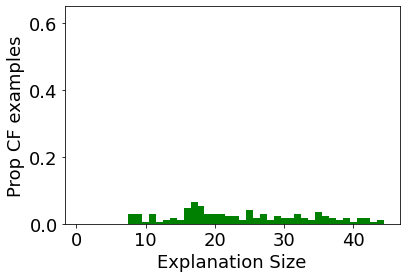

In [9]:

font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot graph loss of cf examples
bins = [i+0.5 for i in range(45)]
plt.hist(df["loss_graph_dist"], bins=bins, color='g', weights=np.ones(len(df))/len(df))
plt.xlabel("Explanation Size")
plt.xticks([0, 10, 20, 30, 40])
plt.ylim(0, 0.65)
plt.ylabel("Prop CF examples")

In [8]:
# For accuracy, only look at motif nodes

df_motif = df[df["y_pred_orig"] != 0].reset_index(drop=True)

accuracy = []

# Get original predictions 
dict_ypred_orig = dict(zip(sorted(np.concatenate((idx_train.numpy(), idx_test.numpy()))), 
                           y_pred_orig.numpy()))

for i in range(len(df_motif)):
    node_idx = df_motif["node_idx"][i]
    new_idx = df_motif["new_idx"][i]

    _, _, _, node_dict = get_neighbourhood(int(node_idx), edge_index, 4, features, labels)

    # Confirm idx mapping is correct
    if node_dict[node_idx] == df_motif["new_idx"][i]:

        cf_adj = df_motif["cf_adj"][i]
        sub_adj = df_motif["sub_adj"][i]
        perturb = np.abs(cf_adj - sub_adj)
        perturb_edges = np.nonzero(perturb)        # Edge indices

        nodes_involved = np.unique(np.concatenate((perturb_edges[0], perturb_edges[1]), axis=0))
        perturb_nodes = nodes_involved[nodes_involved != new_idx]   # Remove original node

        # Retrieve original node idxs for original predictions
        perturb_nodes_orig_idx = []
        for j in perturb_nodes:
            perturb_nodes_orig_idx.append([key for (key, value) in node_dict.items() if value == j])
        perturb_nodes_orig_idx = np.array(perturb_nodes_orig_idx).flatten()

        # Retrieve original predictions
        perturb_nodes_orig_ypred = np.array([dict_ypred_orig[k] for k in perturb_nodes_orig_idx])
        nodes_in_motif = perturb_nodes_orig_ypred[perturb_nodes_orig_ypred != 0]
        prop_correct = len(nodes_in_motif)/len(perturb_nodes_orig_idx)

        accuracy.append([node_idx, new_idx, perturb_nodes_orig_idx, 
                        perturb_nodes_orig_ypred, nodes_in_motif, prop_correct])

df_accuracy = pd.DataFrame(accuracy, columns=["node_idx", "new_idx", "perturb_nodes_orig_idx", 
                        "perturb_nodes_orig_ypred", "nodes_in_motif", "prop_correct"])



print("Accuracy", np.mean(df_accuracy["prop_correct"]))

Accuracy 0.7223317359548266
